<a href="https://colab.research.google.com/github/bori00/BrainTumorClassification/blob/bori_dev/BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification

## Setup

In [1]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

import urllib
from urllib import request

import time

In [2]:
pip install -U matplotlib

In [3]:
# Reproducability
SEED = 31415
def set_seed(seed=SEED):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

## Import Dataset

In [4]:
# mount google drive on the virtual machine created by colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# unzip the files containing the training and testing images
# important: this step assumes that you have the two zip files in 'BrainTumorClassification/Training.zip' and 'BrainTumorClassification/Testing.zip' in your Google Drive
!unzip gdrive/My\ Drive/BrainTumorClassification/Training.zip
!unzip gdrive/My\ Drive/BrainTumorClassification/Testing.zip

## Create Dataframes

In [6]:
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 32

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'Training',
  shuffle=True,
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=IMAGE_SIZE, 
  batch_size=BATCH_SIZE)

valid_ds = tf.keras.utils.image_dataset_from_directory(
  'Training',
  shuffle=True,
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=IMAGE_SIZE, 
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  'Testing',
  shuffle=True,
  seed=SEED,
  image_size=IMAGE_SIZE, 
  batch_size=BATCH_SIZE)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.


In [8]:
for x, y in train_ds.take(1):
  print("Shape of one batch in the   training dataset: ", x.shape, " with labels:", y)

for x, y in valid_ds.take(1):
  print("Shape of one batch in the validation dataset: ", x.shape, " with labels:", y)

for x, y in test_ds.take(1):
  print("Shape of one batch in the    testing dataset: ", x.shape, " with labels:", y)

Shape of one batch in the   training dataset:  (32, 512, 512, 3)  with labels: tf.Tensor([3 1 1 2 1 0 1 1 3 0 1 2 1 3 3 3 0 2 3 3 3 1 2 2 3 1 3 0 1 3 3 0], shape=(32,), dtype=int32)
Shape of one batch in the validation dataset:  (32, 512, 512, 3)  with labels: tf.Tensor([3 1 0 1 3 3 1 0 2 1 2 0 2 1 0 1 0 3 3 0 3 2 1 0 1 1 0 2 3 3 0 3], shape=(32,), dtype=int32)
Shape of one batch in the    testing dataset:  (32, 512, 512, 3)  with labels: tf.Tensor([3 3 1 0 2 0 2 2 3 1 2 1 2 0 2 1 2 1 2 0 2 0 1 0 1 1 2 3 1 1 2 3], shape=(32,), dtype=int32)


In [9]:
class_names = train_ds.class_names
print("Class Names: ", class_names)

Class Names:  ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


### Distributions

In [79]:
def get_distribution(ds):
  vals = np.unique(np.fromiter(ds.unbatch().map(lambda x, y: y), float), return_counts=True)
  dist = [0, 0, 0, 0]

  for val, count in zip(*vals):
    dist[int(val)] = count
  
  return dist

In [80]:
training_dist = get_distribution(train_ds)
valid_dist = get_distribution(valid_ds)
testing_dist = get_distribution(test_ds)

In [81]:
training_dist

[667, 653, 305, 671]

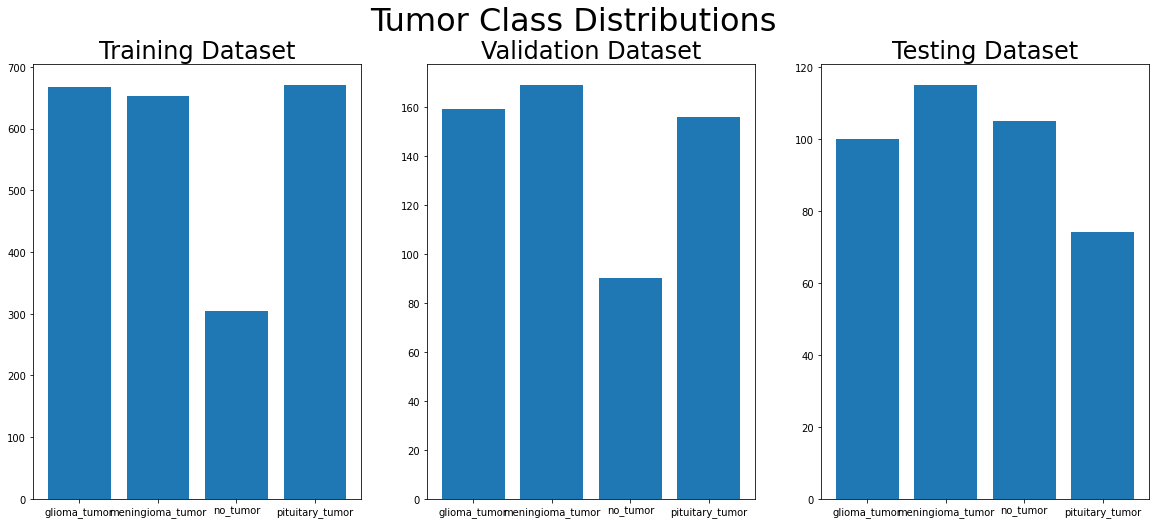

In [92]:
plt.figure(figsize=(20, 8))
plt.suptitle("Tumor Class Distributions", fontsize = 32)

plt.subplot(1, 3, 1)
plt.title("Training Dataset", fontsize = 24)
plt.bar(range(len(training_dist)), training_dist, tick_label=class_names)

plt.subplot(1, 3, 2)
plt.title("Validation Dataset", fontsize = 24)
plt.bar(range(len(valid_dist)), valid_dist, tick_label=class_names)

plt.subplot(1, 3, 3)
plt.title("Testing Dataset", fontsize = 24)
plt.bar(range(len(testing_dist)), testing_dist, tick_label=class_names)

plt.show()

The training and validation dataset are well-balanced, as they were programatically generated, but the test dataset, downloaded from kaggle, has a significantly different class distribution from that of the other datasets: the no_tumor class is overrepresented in the test dataset compared to the other two.

## Visualize data

In [33]:
def categorize_images(batch):
  cardinalities = [0, 0, 0, 0]
  cat_images = [[], [], [], []]

  for images, labels in batch:
    for i in range(images.shape[0]):
        category = int(labels[i])
        cardinalities[category] = cardinalities[category] + 1
        cat_images[category].append(images[i].numpy().astype("uint8"))
  
  return cat_images, cardinalities

In [59]:
def visualize_batch_per_categories(batch):
  cat_images, cardinalities = categorize_images(batch)

  no_columns = max(cardinalities)

  # create 4x1 subplots
  fig, axs = plt.subplots(nrows=4, ncols=1, constrained_layout=True)
  fig.set_figheight(20)
  fig.set_figwidth(4 * no_columns)
  fig.suptitle('The content of one Batch', fontsize = 64)

  # clear subplots
  for ax in axs:
      ax.remove()

  # add subfigure per subplot
  gridspec = axs[0].get_subplotspec().get_gridspec()
  subfigs = [fig.add_subfigure(gs) for gs in gridspec]

  for row, subfig in enumerate(subfigs):
      subfig.suptitle(class_names[row], fontsize = 32)

      # create 1x3 subplots per subfig
      axs = subfig.subplots(nrows=1, ncols=no_columns)
      for col, ax in enumerate(axs):
          if (cardinalities[row] > col):
            ax.plot()
            ax.imshow(cat_images[row][col-1])

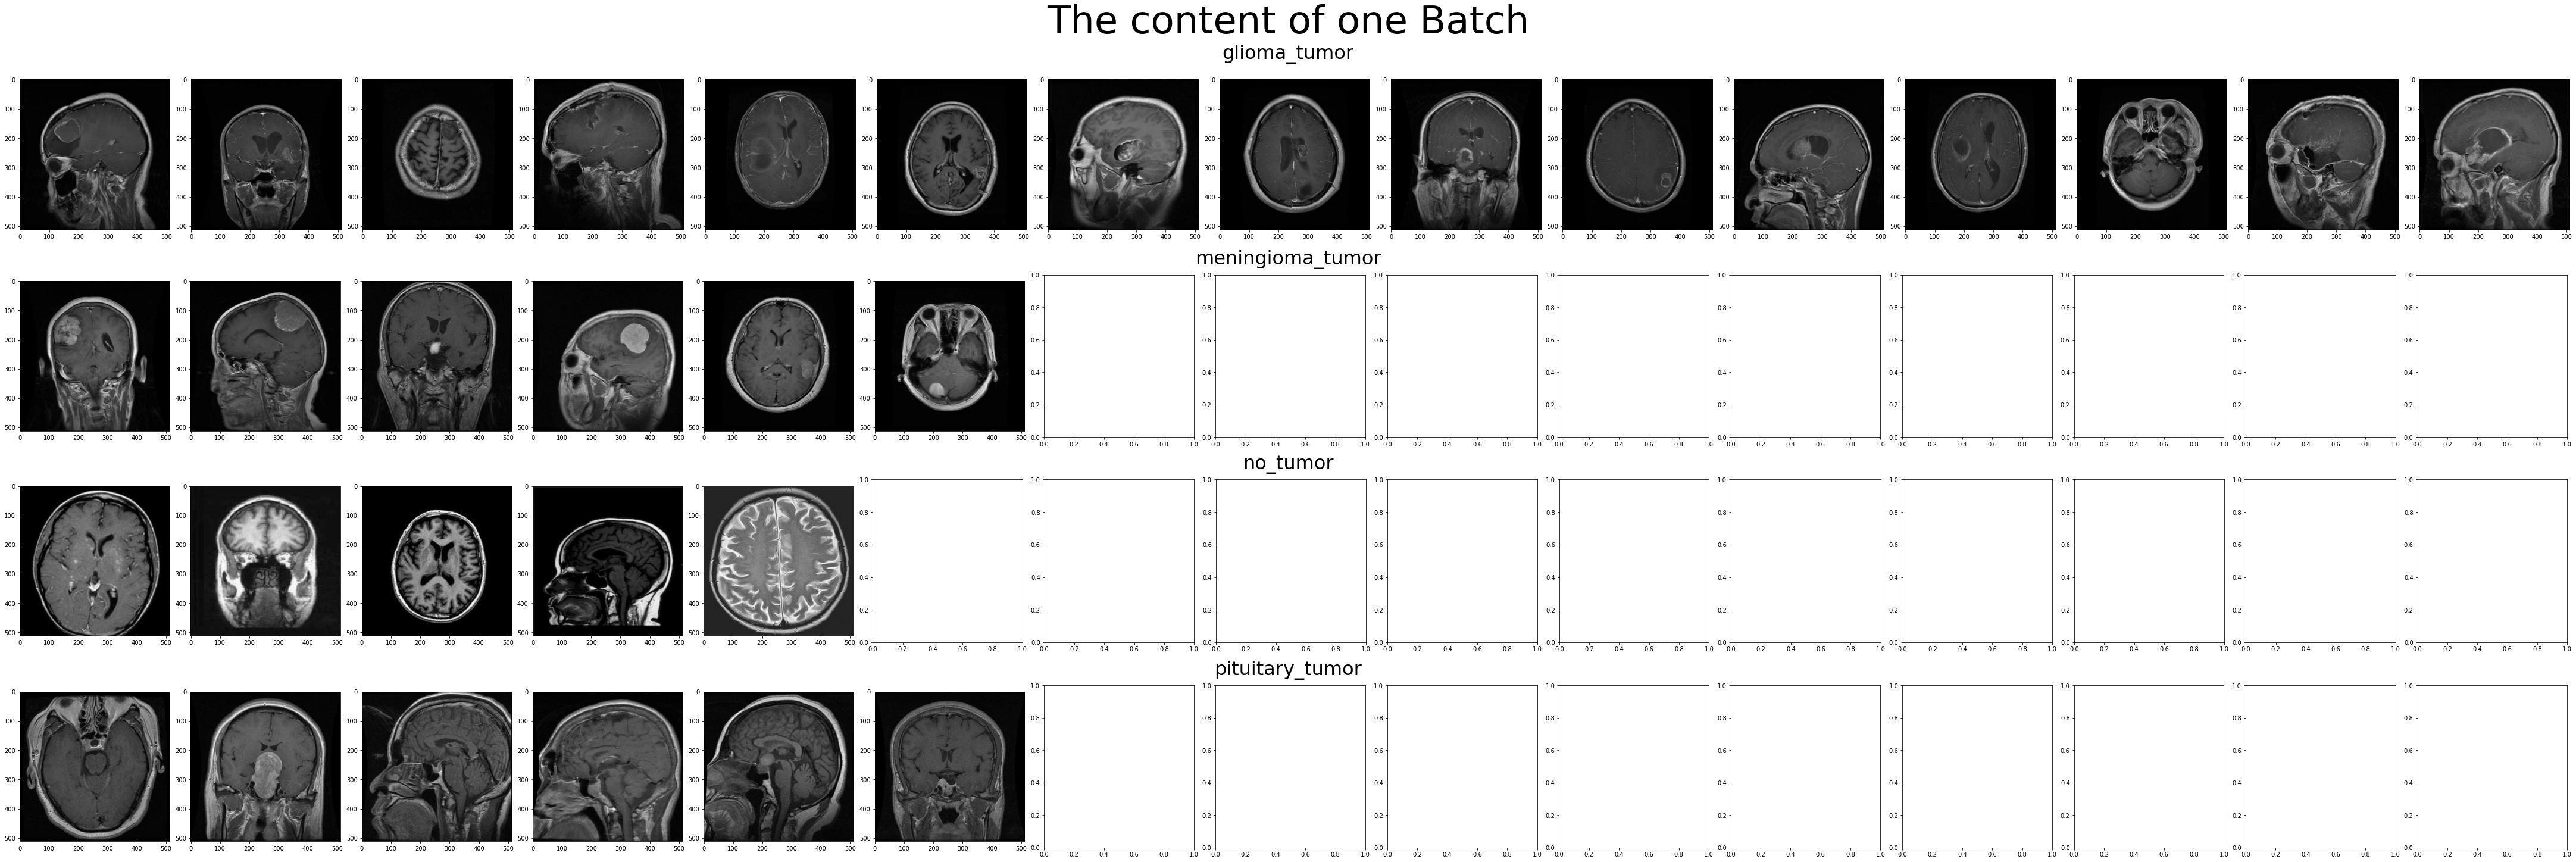

In [60]:
visualize_batch_per_categories(train_ds.take(1))